In [5]:
import numpy as np
import torch, os, cv2
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [6]:
N = 40
R, C = 580, 890
M = R*C
W = 25

In [7]:
# bring captured image

# 580, 890, N, 3 / N : illumination 개수
b = np.stack([cv2.imread("test_2023_05_08_13_16_160ms_crop/calibration0/capture_%04d.png"%i) for i in range(N)], axis=2)
b = b[:,:,:,::-1]/255.
print(b.shape)

(580, 890, 40, 3)


In [8]:
# bring illumination numpy array
# 580, 890, 40, 25
A = np.load("./illum_data.npy")[0]
print(A.shape)

(516200, 40, 25)


In [9]:
# bring camera response function
# 25, 3
cam_crf = np.load(os.path.join("./dataset/image_formation/CRF_cam.npy"))
map_scale = interp1d([cam_crf.min(), cam_crf.max()], [0.,1.])
cam_crf = map_scale(cam_crf).astype(np.float32)
cam_crf = cam_crf[2:27].T
print(cam_crf.shape)

(3, 25)


In [10]:
# Make M N 3 W

A = np.expand_dims(A, axis=2)
cam_crf = np.expand_dims(np.expand_dims(cam_crf, axis =0), axis=0)
A = A * cam_crf

In [11]:
def total_variation_loss_l2(img, weight): 
    bs_img, c_img, h_img, w_img = img.size() 
    tv_h = torch.pow(img[:,:,1:,:]-img[:,:,:-1,:], 2).sum() 
    tv_w = torch.pow(img[:,:,:,1:]-img[:,:,:,:-1], 2).sum() 
    return weight*(tv_h+tv_w)/(bs_img*c_img*h_img*w_img)

In [12]:
def total_variation_loss_l1(img, weight): 
    bs_img, c_img, h_img, w_img = img.size() 
    tv_h = torch.abs(img[:,:,1:,:]-img[:,:,:-1,:]).sum() 
    tv_w = torch.abs(img[:,:,:,1:]-img[:,:,:,:-1]).sum() 
    return weight*(tv_h+tv_w)/(bs_img*c_img*h_img*w_img)

In [13]:
def total_variation_loss_l2_spectrum(img, weight): 
    bs_img, c_img, h_img, w_img = img.size() 
    tv_s = torch.pow(img[:,1:,:,:]-img[:,:-1,:,:], 2).sum()
    return weight*(tv_s)/(bs_img*c_img*h_img*w_img)

### Optimize with TV Loss + L1 loss

In [14]:
# Reshape for tv loss

r, c = 290, 445

A = A.reshape(R, C, 1, 3*N, W)
b = b.reshape(R, C, 1, 3*N, 1)

A1 = A[:r,:c]
A2 = A[:r,c:]
A3 = A[r:,:c]
A4 = A[r:,c:]

b1 = b[:r,:c]
b2 = b[:r,c:]
b3 = b[r:,:c]
b4 = b[r:,c:]

A_list = [A1,A2,A3,A4]
b_list = [b1,b2,b3,b4]

In [15]:
batch_size = 100000
num_iter = 5000
num_batches = int(np.ceil(M / batch_size))
loss_f = torch.nn.L1Loss()
losses = []
X_np_all = torch.zeros(R, C, 1, W, 1)

# define initial learning rate and decay step
lr = 1
decay_step = 500


# training loop over batches
for batch_idx in range(4):
    A_batch = torch.from_numpy(A_list[batch_idx]).to(device).reshape(r*c,1, 3*N, W)
    B_batch = torch.from_numpy(b_list[batch_idx]).to(device).reshape(r*c,1, 3*N, 1)
    X_est = torch.randn(r*c, 1, W, 1, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([X_est], lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=0.5)

    optimizer.zero_grad()
    for i in range(num_iter):
        loss = loss_f(A_batch @ X_est, B_batch)
        X_est_reshape = X_est.reshape(r,c,W).unsqueeze(dim = 0).permute(0,3,1,2)
        loss_tv = total_variation_loss_l1(X_est_reshape, 0.1)
        loss_spec = total_variation_loss_l2_spectrum(X_est_reshape, 0.1)
        total_loss = loss + loss_tv + loss_spec
        
        total_loss.backward()
        losses.append(total_loss.item())
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if i % 100 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}, Iteration {i}/{num_iter}, Loss: {loss.item()}, TV Loss: {loss_tv.item()}, Spec Loss: {loss_spec.item()},  LR: {optimizer.param_groups[0]['lr']}")

    if batch_idx == 0:
        X_np_all[:r,:c]= X_est.detach().cpu().reshape(r,c,1,W,1)
    elif batch_idx == 1:
        X_np_all[:r,c:]= X_est.detach().cpu().reshape(r,c,1,W,1)
    elif batch_idx == 2:
        X_np_all[r:,:c]= X_est.detach().cpu().reshape(r,c,1,W,1)
    else:
        X_np_all[r:,c:]= X_est.detach().cpu().reshape(r,c,1,W,1)

X_np_all = X_np_all.numpy()

Batch 1/6, Iteration 0/5000, Loss: 0.14287865884755138, TV Loss: 0.2248942255973816, Spec Loss: 0.19181911647319794,  LR: 1
Batch 1/6, Iteration 100/5000, Loss: 0.06511272987371174, TV Loss: 0.020621109753847122, Spec Loss: 0.0014404109679162502,  LR: 1
Batch 1/6, Iteration 200/5000, Loss: 0.06521877628618758, TV Loss: 0.020760245621204376, Spec Loss: 0.0014445865526795387,  LR: 1
Batch 1/6, Iteration 300/5000, Loss: 0.06527100747267098, TV Loss: 0.02083859033882618, Spec Loss: 0.0014472014736384153,  LR: 1
Batch 1/6, Iteration 400/5000, Loss: 0.06529066300949753, TV Loss: 0.02086946740746498, Spec Loss: 0.0014498012606054544,  LR: 1
Batch 1/6, Iteration 500/5000, Loss: 0.06526760809550469, TV Loss: 0.020833831280469894, Spec Loss: 0.0014484679559245706,  LR: 0.5
Batch 1/6, Iteration 600/5000, Loss: 0.05953177532107717, TV Loss: 0.010455123148858547, Spec Loss: 0.0007689215708523989,  LR: 0.5
Batch 1/6, Iteration 700/5000, Loss: 0.059582202311852794, TV Loss: 0.010534349828958511, Spec

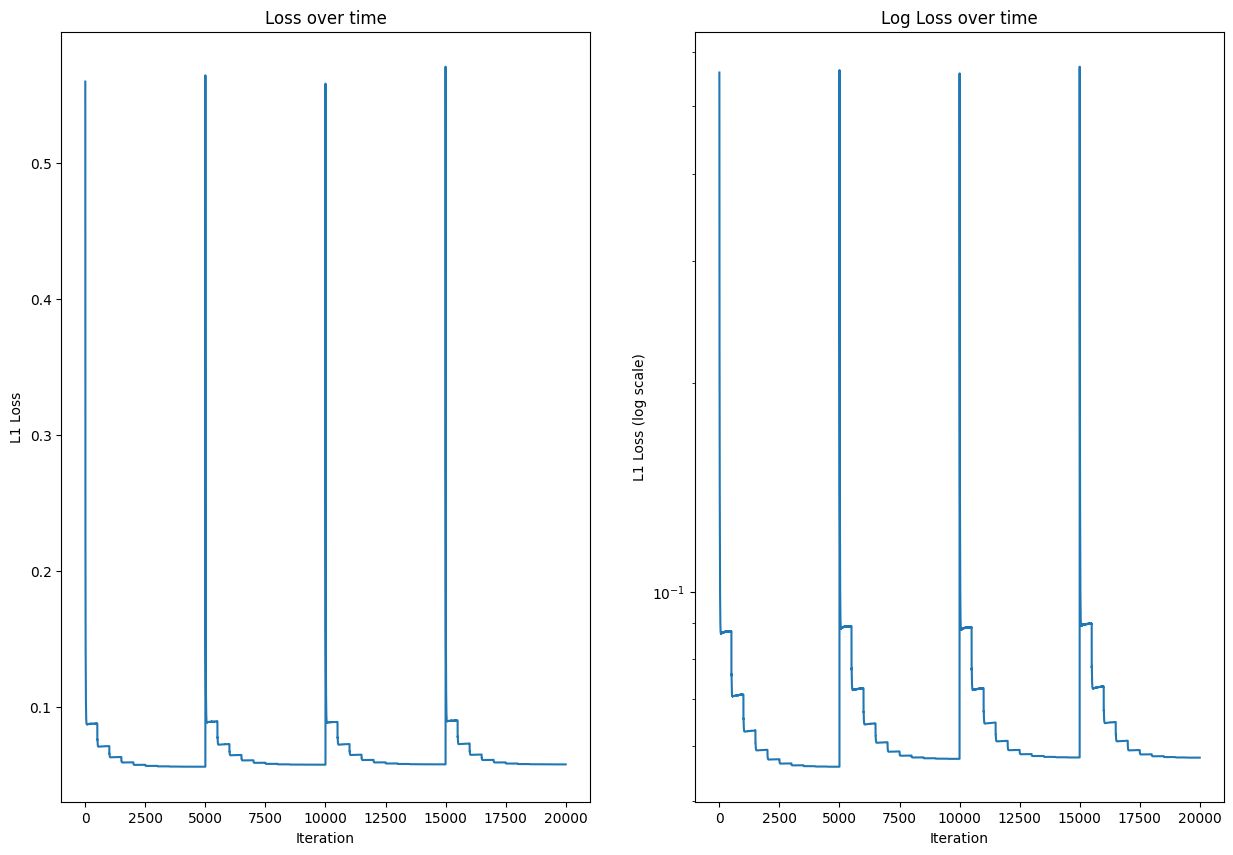

In [16]:
# plot losses over time
plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Loss over time")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss")

plt.subplot(1, 2, 2)
plt.semilogy(losses)
plt.title("Log Loss over time")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss (log scale)")

plt.show()


In [17]:
X_np_all = X_np_all.reshape(R, C, W)

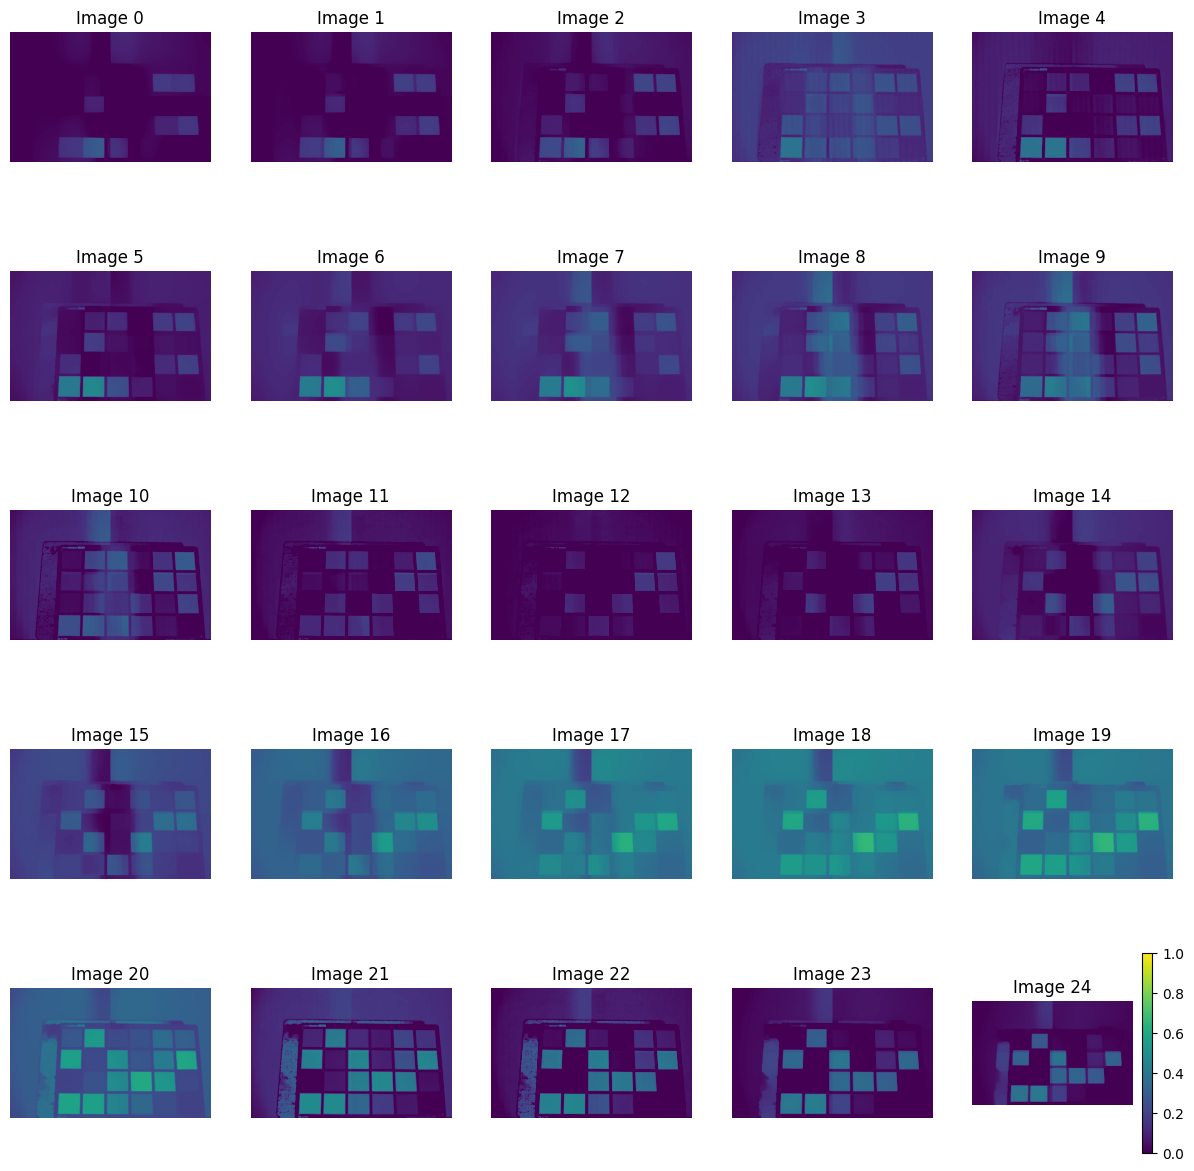

In [18]:
max_images_per_column = 5
num_columns = (W + max_images_per_column - 1) // max_images_per_column
plt.figure(figsize=(15, 3*num_columns))

for c in range(num_columns):
    start_index = c * max_images_per_column
    end_index = min(start_index + max_images_per_column, W)
    num_images = end_index - start_index
    
    for i in range(num_images):
        plt.subplot(num_columns, num_images, i + c * num_images + 1)
        plt.imshow(X_np_all[:, :, i + start_index], vmin=0, vmax=1)
        plt.axis('off')
        plt.title(f"Image {i + start_index}")
        
        if i + start_index == W - 1:
            plt.colorbar()

In [19]:
X_np_all.shape

(580, 890, 25)

In [20]:
CRF = cam_crf.reshape(3,25).T

In [21]:
rgb_img = X_np_all@CRF

In [22]:
rgb_img.shape

(580, 890, 3)

In [25]:
rgb_img.max()

3.5072777

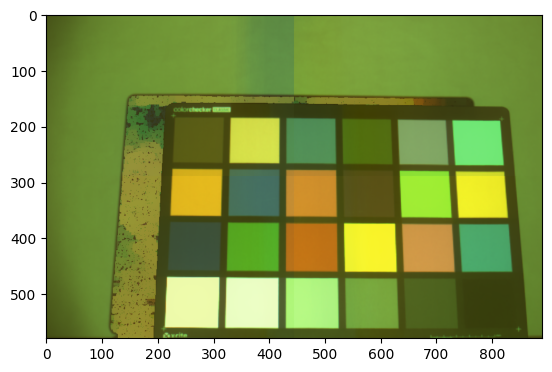

In [27]:
plt.imshow(rgb_img / rgb_img.max())

In [26]:
cv2.imwrite('./rgb_img.png', (rgb_img / rgb_img.max())*255.)

True

### Optimize with L1 loss

In [24]:
# Reshape to make M, ...
# A = A.reshape(R*C, 1, 3*N, W)
# b = b.reshape(R*C, 1, 3*N, 1)    
    
batch_size = 100000
num_iter = 2000
num_batches = int(np.ceil(M / batch_size))
loss_f = torch.nn.L1Loss()
losses = []
X_np_all = torch.zeros(M, 1, W, 1)

# define initial learning rate and decay step
lr = 0.5
decay_step = 250

# training loop over batches
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, M)
    batch_size_ = end_idx - start_idx
    A_batch = torch.from_numpy(A[start_idx:end_idx]).to(device)
    B_batch = torch.from_numpy(b[start_idx:end_idx]).to(device)
    X_est = torch.randn(batch_size_, 1, W, 1, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([X_est], lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=0.5)

    optimizer.zero_grad()
    for i in range(num_iter):
        loss = loss_f(A_batch @ X_est, B_batch)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if i % 100 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}, Iteration {i}/{num_iter}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")

    X_np_all[start_idx:end_idx] = X_est.detach().cpu()

X_np_all = X_np_all.numpy()

Batch 1/6, Iteration 0/2000, Loss: 0.11126841667823405, LR: 0.5
Batch 1/6, Iteration 100/2000, Loss: 0.020637000408660976, LR: 0.5
Batch 1/6, Iteration 200/2000, Loss: 0.0203494767906188, LR: 0.5
Batch 1/6, Iteration 300/2000, Loss: 0.01459103672164999, LR: 0.25
Batch 1/6, Iteration 400/2000, Loss: 0.014559005126837783, LR: 0.25
Batch 1/6, Iteration 500/2000, Loss: 0.014524012691704813, LR: 0.125
Batch 1/6, Iteration 600/2000, Loss: 0.011849022468043743, LR: 0.125
Batch 1/6, Iteration 700/2000, Loss: 0.011842275411608164, LR: 0.125
Batch 1/6, Iteration 800/2000, Loss: 0.010700888496502636, LR: 0.0625
Batch 1/6, Iteration 900/2000, Loss: 0.01069088753635553, LR: 0.0625
Batch 1/6, Iteration 1000/2000, Loss: 0.010686943040562811, LR: 0.03125
Batch 1/6, Iteration 1100/2000, Loss: 0.010237849259806501, LR: 0.03125
Batch 1/6, Iteration 1200/2000, Loss: 0.010234086379660393, LR: 0.03125
Batch 1/6, Iteration 1300/2000, Loss: 0.010053742258594622, LR: 0.015625
Batch 1/6, Iteration 1400/2000, Lo

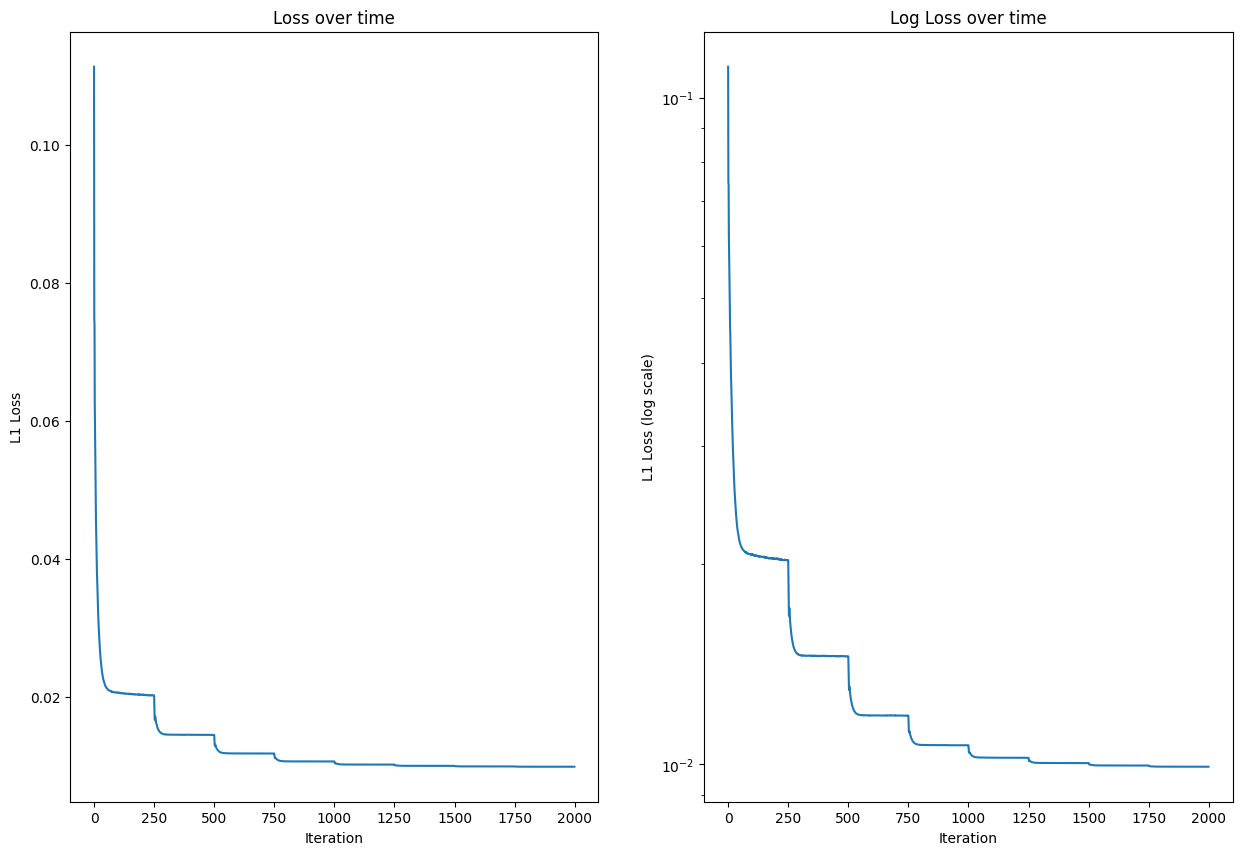

In [25]:
# plot losses over time
plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
plt.plot(losses[:2000])
plt.title("Loss over time")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss")

plt.subplot(1, 2, 2)
plt.semilogy(losses[:2000])
plt.title("Log Loss over time")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss (log scale)")

plt.show()

In [26]:
X_np_all.shape

(516200, 1, 25, 1)

In [27]:
X_np_all = X_np_all.reshape(R, C, 25)

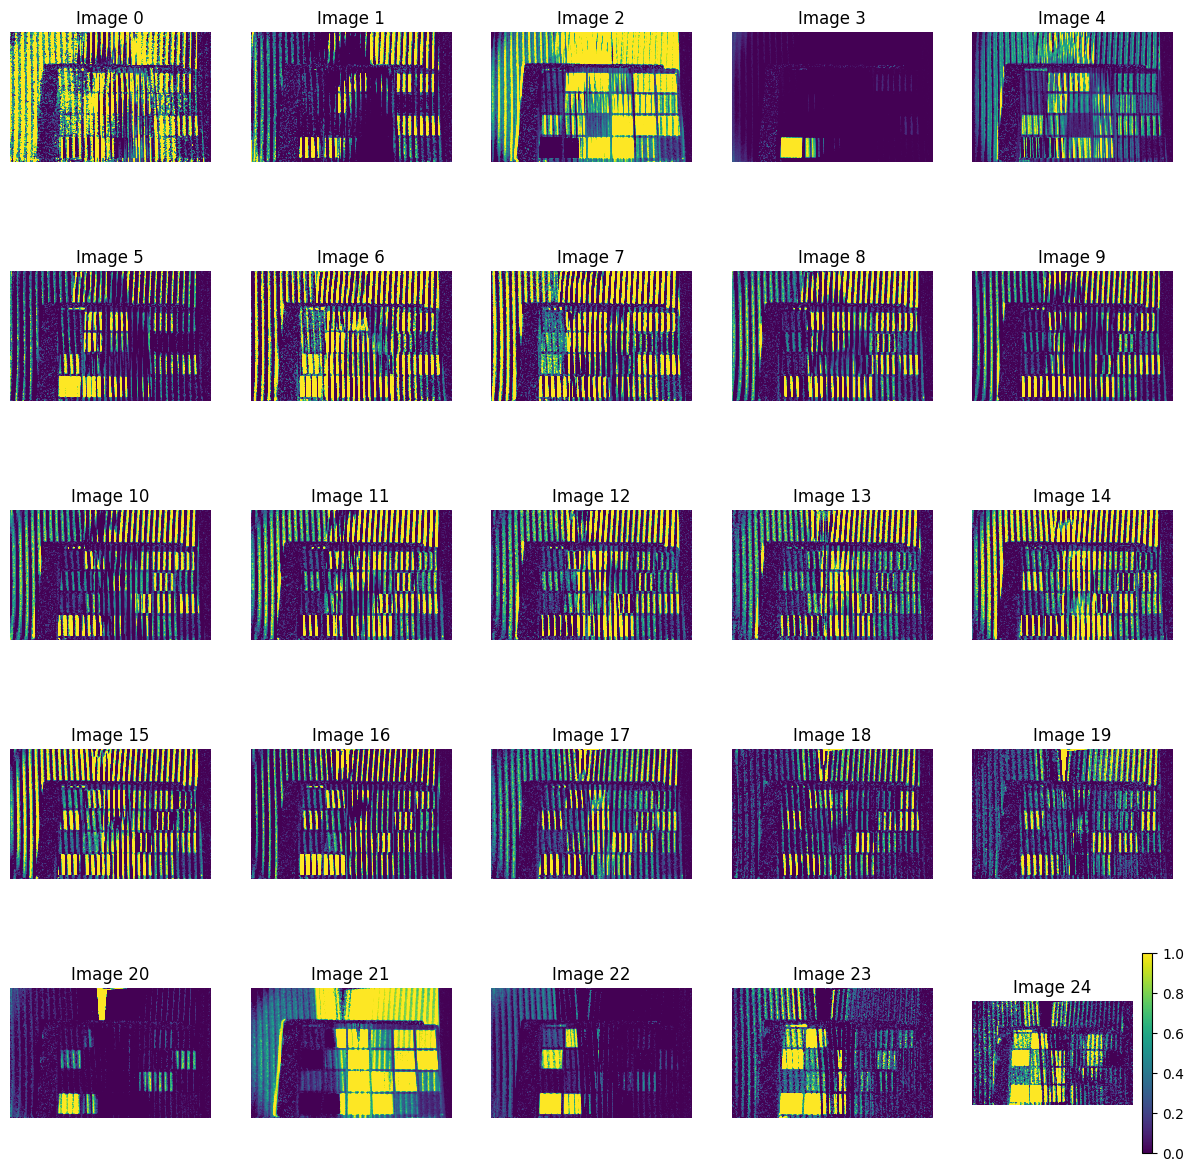

In [28]:
max_images_per_column = 5
num_columns = (W + max_images_per_column - 1) // max_images_per_column
plt.figure(figsize=(15, 3*num_columns))

for c in range(num_columns):
    start_index = c * max_images_per_column
    end_index = min(start_index + max_images_per_column, W)
    num_images = end_index - start_index
    
    for i in range(num_images):
        plt.subplot(num_columns, num_images, i + c * num_images + 1)
        plt.imshow(X_np_all[:, :, i + start_index], vmin=0, vmax=1)
        plt.axis('off')
        plt.title(f"Image {i + start_index}")
        
        if i + start_index == W - 1:
            plt.colorbar()

In [14]:
A = A.reshape(R, C, 1, 3*N, W)
b = b.reshape(R, C, 1, 3*N, 1)

A1 = A[:290,:445]
A2 = A[:290,445:]
A3 = A[290:,:445]
A4 = A[290:,445:]

b1 = b[:290,:445]
b2 = b[:290,445:]
b3 = b[290:,:445]
b4 = b[290:,445:]

A_list = [A1,A2,A3,A4]
b_list = [b1,b2,b3,b4]